# New Features

From https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset
or https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020/data

We learned :

- tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).

- heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.

- power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.

- overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.

- random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.


## Load Data And Dependencies

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
X_train=pd.read_csv('X_train.csv')
y_train=pd.read_csv('y_train.csv')
X_test=pd.read_csv('X_test.csv')
y_test=pd.read_csv('y_test.csv')
df_train=pd.concat([X_train, y_train], axis=1)
df_test=pd.concat([X_test, y_test], axis=1)

# Strain And Over Strain Failure

In [11]:
min_strain_for_failure=df_train[df_train['OSF'] == 1]['Strain [minNm]'].min()
print(f'Minimum strain for failure: {min_strain_for_failure}')
max_strain_for_non_failure=df_train[df_train['OSF'] == 0]['Strain [minNm]'].max()
print(f'Maximum strain for non failure: {max_strain_for_non_failure}')

Minimum strain for failure: 11019.2
Maximum strain for non failure: 11919.8


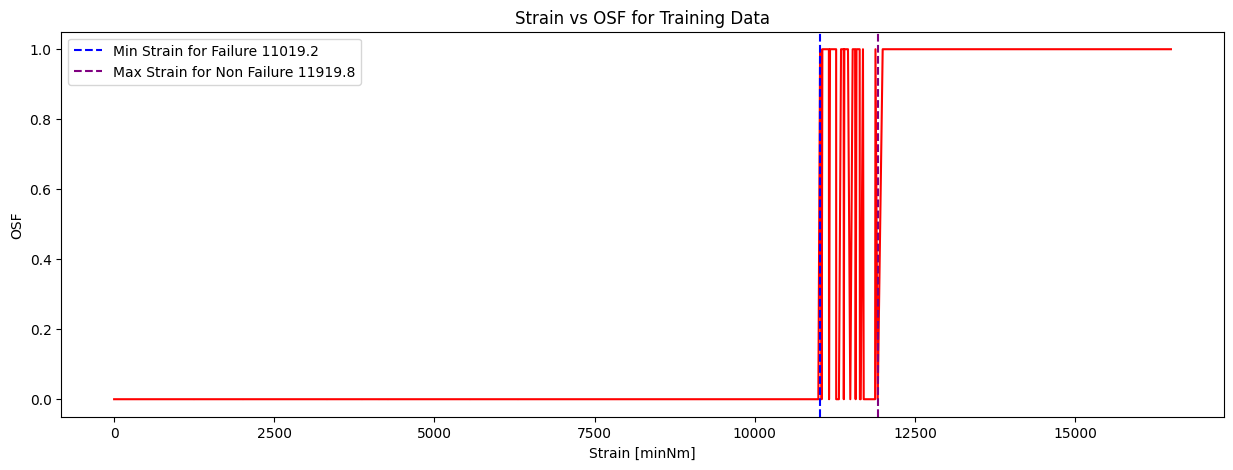

In [12]:
plt.figure(figsize=(15, 5)) # Set the size of the resulting plot
sns.lineplot(data=df_train, x='Strain [minNm]', y='OSF', color='red')
plt.axvline(x=min_strain_for_failure, color='blue', linestyle='--', label=f'Min Strain for Failure {min_strain_for_failure}')
plt.axvline(x=max_strain_for_non_failure, color='purple', linestyle='--', label=f'Max Strain for Non Failure {max_strain_for_non_failure}')
plt.xlabel('Strain [minNm]')
plt.ylabel('OSF')
plt.title(f'Strain vs OSF for Training Data')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Over Strain Failure')

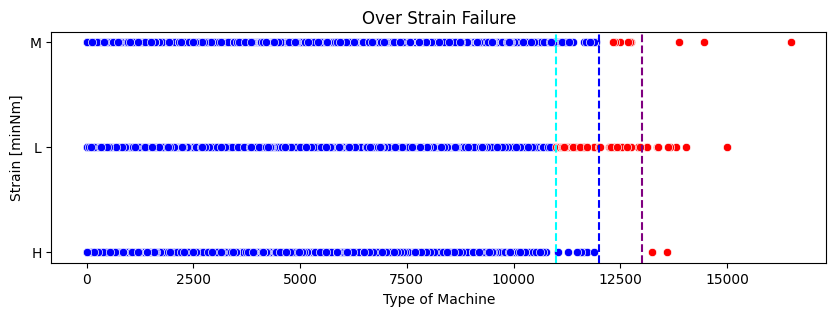

In [68]:
plt.figure(figsize=(10, 3))
sns.scatterplot(data=df[df['OSF']==0], x='Strain [minNm]', y='Type', color='blue')
sns.scatterplot(data=df[df['OSF']==1], x='Strain [minNm]', y='Type', color='red')
plt.axvline(11000, color='cyan', linestyle='--', label='Strain 11000 minNm (L)')
plt.axvline(12000, color='blue', linestyle='--', label='Strain 12000 minNm (M)')
plt.axvline(13000, color='purple', linestyle='--', label='Strain 13000 minNm (H)')
plt.xlabel('Type of Machine')
plt.ylabel('Strain [minNm]')
plt.title('Over Strain Failure')

# Power and Power Failure

In [69]:
df['Power (W)'] = df['Rotational speed [rpm]'] * df['Torque [Nm]'] * 2 * np.pi / 60

Text(0.5, 1.0, 'Power vs PWF')

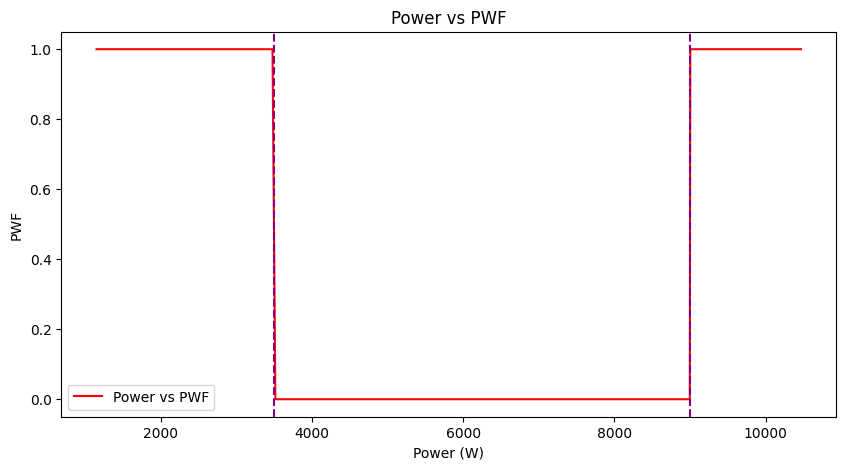

In [70]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Power (W)', y='PWF', color='red', label='Power vs PWF')
plt.axvline(3500, color='purple', linestyle='--', label='Power 3500W')
plt.axvline(9000, color='purple', linestyle='--', label='Power 9000W')
plt.xlabel('Power (W)')
plt.ylabel('PWF')
plt.title('Power vs PWF')


# Temperature Difference And Heat Dissipation Failure

In [71]:
df['Temperature Difference (K)'] = df['Process temperature [K]'] - df['Air temperature [K]']


Text(0.5, 1.0, 'Heat Dissipation Failure')

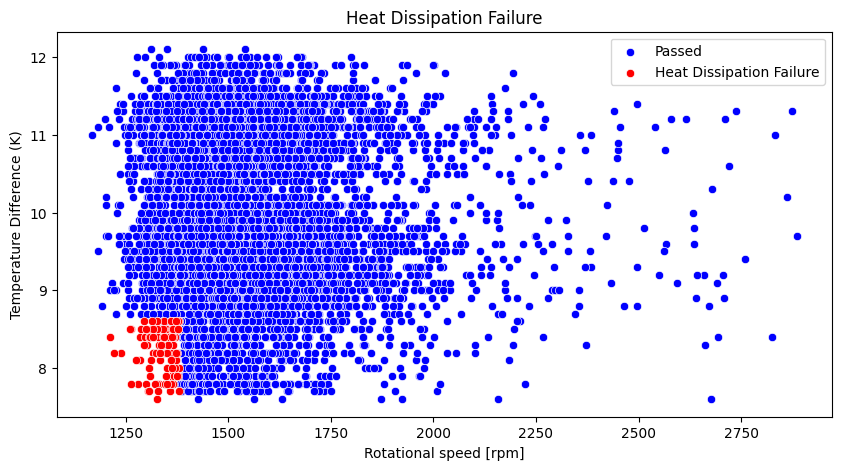

In [72]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df[df['HDF']==0], x='Rotational speed [rpm]', y='Temperature Difference (K)', color='blue', label='Passed')
sns.scatterplot(data=df[df['HDF']==1], x='Rotational speed [rpm]', y='Temperature Difference (K)', color='red', label='Heat Dissipation Failure')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Temperature Difference (K)')
plt.title('Heat Dissipation Failure')

Here we are not able to use simple threshold to detect failures

# Threshold Predictor Model

When we create a threshold prediction model, we try our best to avoid insider knowledge given we already know the data characteristic and how the failures are generated.

In [85]:
class ThresholdPredictor:
    def __init__(self):
        self.power_feature = 'Power (W)'
        self.power_low_threshold = 3500 # the minimum power where PWF Occurs
        self.power_high_threshold = 9000 # the maximum power where PWF Occurs
        self.strain_feature = 'Strain [minNm]'
        self.strain_threshold = 11000 # the minimum strain where OSF Occurs
        self.temperature_feature = 'Temperature Difference (K)'
        self.temperature_threshold = 8.6 # the minimum temperature difference when HDF occurs
    def fit(self, X, y):
        pass  # No fitting needed for threshold-based model

    def predict(self, X):
        return np.where(
            (X[self.power_feature] <= self.power_low_threshold) | 
            (X[self.power_feature] >= self.power_high_threshold)
            | (X[self.strain_feature] >= self.strain_threshold)
            | (X[self.temperature_feature] <= self.temperature_threshold)
            ,1, 0)
    def score(self, X, y):
        predictions = self.predict(X)
        return (predictions == y).mean()
    
X= df.drop(columns=['Machine failure', 'OSF', 'HDF', 'PWF', 'TWF', 'RNF'])
y = df['Machine failure']
threshold_predictor = ThresholdPredictor()
threshold_predictor.fit(X, y)
print("Threshold Predictor Model Score: ", threshold_predictor.score(X, y))

Threshold Predictor Model Score:  0.9327


In [ ]:
df.to_csv('ai4i2020_new_features.csv', index=False)